<a href="https://colab.research.google.com/github/ChiragShetye/-Business-Case-Scaler---Clustering/blob/main/Business_Case_Study_Scaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
plt.rcParams["figure.figsize"] = (12, 10)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

In [3]:
url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/856/original/scaler_clustering.csv"
df_raw = pd.read_csv(url)
df_raw.sample(10)

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
160511,161153,jtrrgf btootzstq,0782512aeb832269a94ad98935e70378f8e8d79d6ba51d...,2016.0,550000,FullStack Engineer,2019.0
12886,12895,bwpxzotj vza wg,4905648bab5d782653458a07b936089a78fc88675e4629...,2016.0,310000,Other,2020.0
103969,104206,yvog ntwyzgrgsxto,dbc90ab9e531a9c310bb19848b23fba2e4ad2c19753177...,2017.0,400000,FullStack Engineer,2021.0
70921,71020,ouqxzprq,c93b5540244bb46edbb2eb614d9474cb295587de611e3b...,2017.0,1200000,Backend Engineer,2019.0
39322,39368,owqj vzvrjnxwo,96a583769743e5771ef063252eb68f65c7e0a26175d697...,2017.0,1600000,Data Scientist,2020.0
86282,86427,zgn vuurxwvmrt,819cc768d5f1177d01d04c77d25c57be31203d0d05b961...,2019.0,150000,NaN,2021.0
93953,94133,wgszxkvzn,aa5c9ec3e638373b2cc194f418602f7e0fd5460d80b607...,2015.0,500000,NaN,2020.0
119065,119379,iv xzegntwy uqxcvnt rxbxnta,1792157e14733a133af5bfe696da1426520d86bed66153...,2015.0,1050000,Backend Engineer,2021.0
43459,43510,xnw xzegntwy,f20f2d6808dd48b012d9b347026b64efead173d691a7d0...,2005.0,2000000,NaN,2021.0
26303,26329,nmb ntwyzgrgsxto,2601e74fb13a92a1723c05608bff01a338fe03af7cbf74...,2020.0,500000,NaN,2019.0


In [4]:
print(df_raw.shape)
print(df_raw.info())

(205843, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153279 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB
None


In [5]:
print(df_raw.isnull().sum())

Unnamed: 0              0
company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52564
ctc_updated_year        0
dtype: int64


In [6]:
  # Data shape and types
  print(f"Shape of dataset: {df_raw.shape}")
  print(f"Data Types:\n{df_raw.dtypes}")

Shape of dataset: (205843, 7)
Data Types:
Unnamed: 0            int64
company_hash         object
email_hash           object
orgyear             float64
ctc                   int64
job_position         object
ctc_updated_year    float64
dtype: object


In [7]:
# Unique counts
print("Unique Email Hashes:", df_raw['email_hash'].nunique())
print("Unique Company Hashes:", df_raw['company_hash'].nunique())

Unique Email Hashes: 153443
Unique Company Hashes: 37299


In [8]:
# Summary statistics
print(df_raw.describe())

          Unnamed: 0        orgyear           ctc  ctc_updated_year
count  205843.000000  205757.000000  2.058430e+05     205843.000000
mean   103273.941786    2014.882750  2.271685e+06       2019.628231
std     59741.306484      63.571115  1.180091e+07          1.325104
min         0.000000       0.000000  2.000000e+00       2015.000000
25%     51518.500000    2013.000000  5.300000e+05       2019.000000
50%    103151.000000    2016.000000  9.500000e+05       2020.000000
75%    154992.500000    2018.000000  1.700000e+06       2021.000000
max    206922.000000   20165.000000  1.000150e+09       2021.000000


In [9]:
# Check duplicates
duplicates = df_raw.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


Remove Special Characters

In [10]:
import re

# Clean the 'company_hash' column
df_raw['company_hash'] = df_raw['company_hash'].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', str(x)) if pd.notnull(x) else x)

# Clean the 'job_position' column
df_raw['job_position'] = df_raw['job_position'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', str(x)) if pd.notnull(x) else x)

# Clean the 'email_hash' column
df_raw['email_hash'] = df_raw['email_hash'].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', str(x)) if pd.notnull(x) else x)

# Check the cleaned columns
print(df_raw[['company_hash', 'job_position', 'email_hash']].head())

              company_hash        job_position  \
0            atrgxnntxzaxv               Other   
1  qtrxvzwtxzegwgbbrxbxnta  FullStack Engineer   
2             ojzwnvwnxwvx    Backend Engineer   
3                ngpgutaxv    Backend Engineer   
4                qxensqghu  FullStack Engineer   

                                          email_hash  
0  6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...  
1  b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...  
2  4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...  
3  effdede7a2e7c2af664c8a31d9346385016128d66bbc58...  
4  6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...  


In [11]:
# Check missing values
missing_values = df_raw.isnull().sum()
print(f"Missing values:\n{missing_values}")

Missing values:
Unnamed: 0              0
company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52564
ctc_updated_year        0
dtype: int64


In [12]:
df_raw['company_hash'] = df_raw['company_hash'].fillna('Unknown')
df_raw['job_position'] = df_raw['job_position'].fillna('Unknown')

# Display missing values again
print(df_raw.isnull().sum())

Unnamed: 0           0
company_hash         0
email_hash           0
orgyear             86
ctc                  0
job_position         0
ctc_updated_year     0
dtype: int64


In [13]:
# Impute missing values using KNN imputation
numerical_columns = ['ctc', 'orgyear', 'ctc_updated_year']  # Replace with relevant columns
imputer = KNNImputer(n_neighbors=5)
df_raw[numerical_columns] = imputer.fit_transform(df_raw[numerical_columns])

In [14]:
# Check for missing values
df_raw.isnull().sum()

,0
Unnamed: 0,0
company_hash,0
email_hash,0
orgyear,0
ctc,0
job_position,0
ctc_updated_year,0


In [15]:
# Add 'Years of Experience' column
current_year = 2025
df_raw['Years_of_Experience'] = current_year - df_raw['orgyear'].astype(int)

In [16]:
df_raw = df_raw.rename(columns={'Unnamed: 0': 'employee_id','company_hash': 'company','email_hash' : 'email_id','orgyear' : 'Start_year'})

In [17]:
df = df_raw[['employee_id', 'company', 'email_id', 'Start_year', 'ctc', 'job_position', 'ctc_updated_year', 'Years_of_Experience']]
df.head()

,employee_id,company,email_id,Start_year,ctc,job_position,ctc_updated_year,Years_of_Experience
0,0,atrgxnntxzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000.0,Other,2020.0,9
1,1,qtrxvzwtxzegwgbbrxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999.0,FullStack Engineer,2019.0,7
2,2,ojzwnvwnxwvx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000.0,Backend Engineer,2020.0,10
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000.0,Backend Engineer,2019.0,8
4,4,qxensqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000.0,FullStack Engineer,2019.0,8


In [18]:
sorted(df['Start_year'].fillna(0).astype(int).unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 38,
 83,
 91,
 200,
 201,
 206,
 208,
 209,
 1900,
 1970,
 1971,
 1972,
 1973,
 1976,
 1977,
 1979,
 1981,
 1982,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024,
 2025,
 2026,
 2027,
 2028,
 2029,
 2031,
 2101,
 2106,
 2107,
 2204,
 20165]

Removing future years.


In [19]:
# Removing future years.
df = df[~df['Start_year'].isin([0,
 1,
 2,
 3,
 4,
 5,
 6,
 38,
 83,
 91,
 200,
 201,
 206,
 208,
 209,
 1900, 2023,
 2024,
 2025,
 2026,
 2027,
 2028,
 2029,
 2031,
 2101,
 2106,
 2107,
 2204,
 20165])]

In [20]:
# Removing future years
df = df[~(df['Years_of_Experience']<0)]

In [21]:
sorted(df['Start_year'].fillna(0).astype(int).unique())

[1970,
 1971,
 1972,
 1973,
 1976,
 1977,
 1979,
 1981,
 1982,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022]

Univariate Analysis

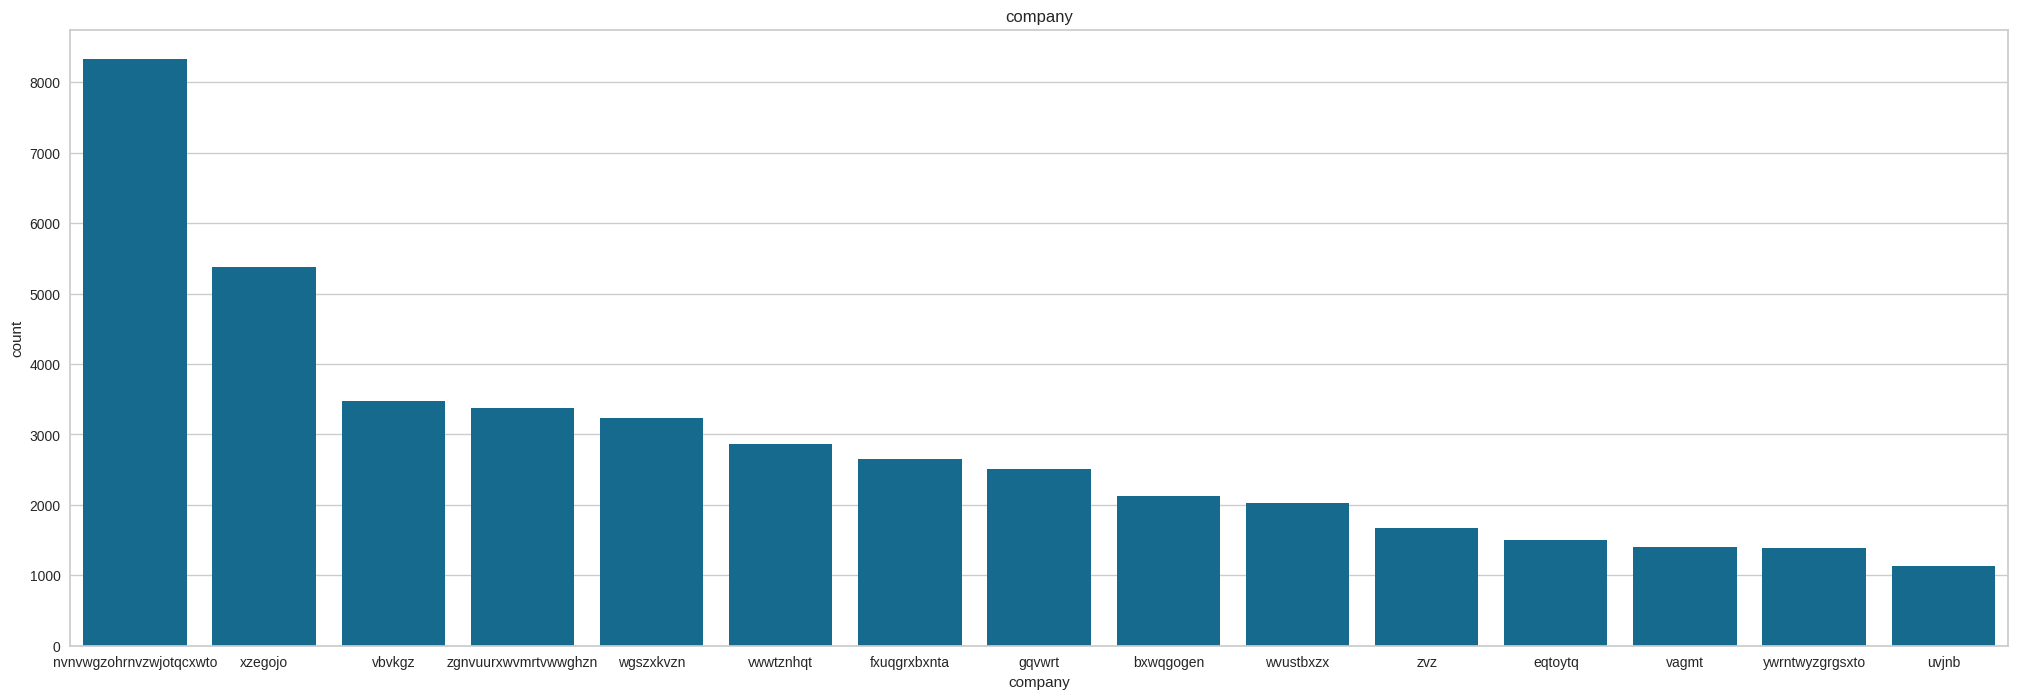

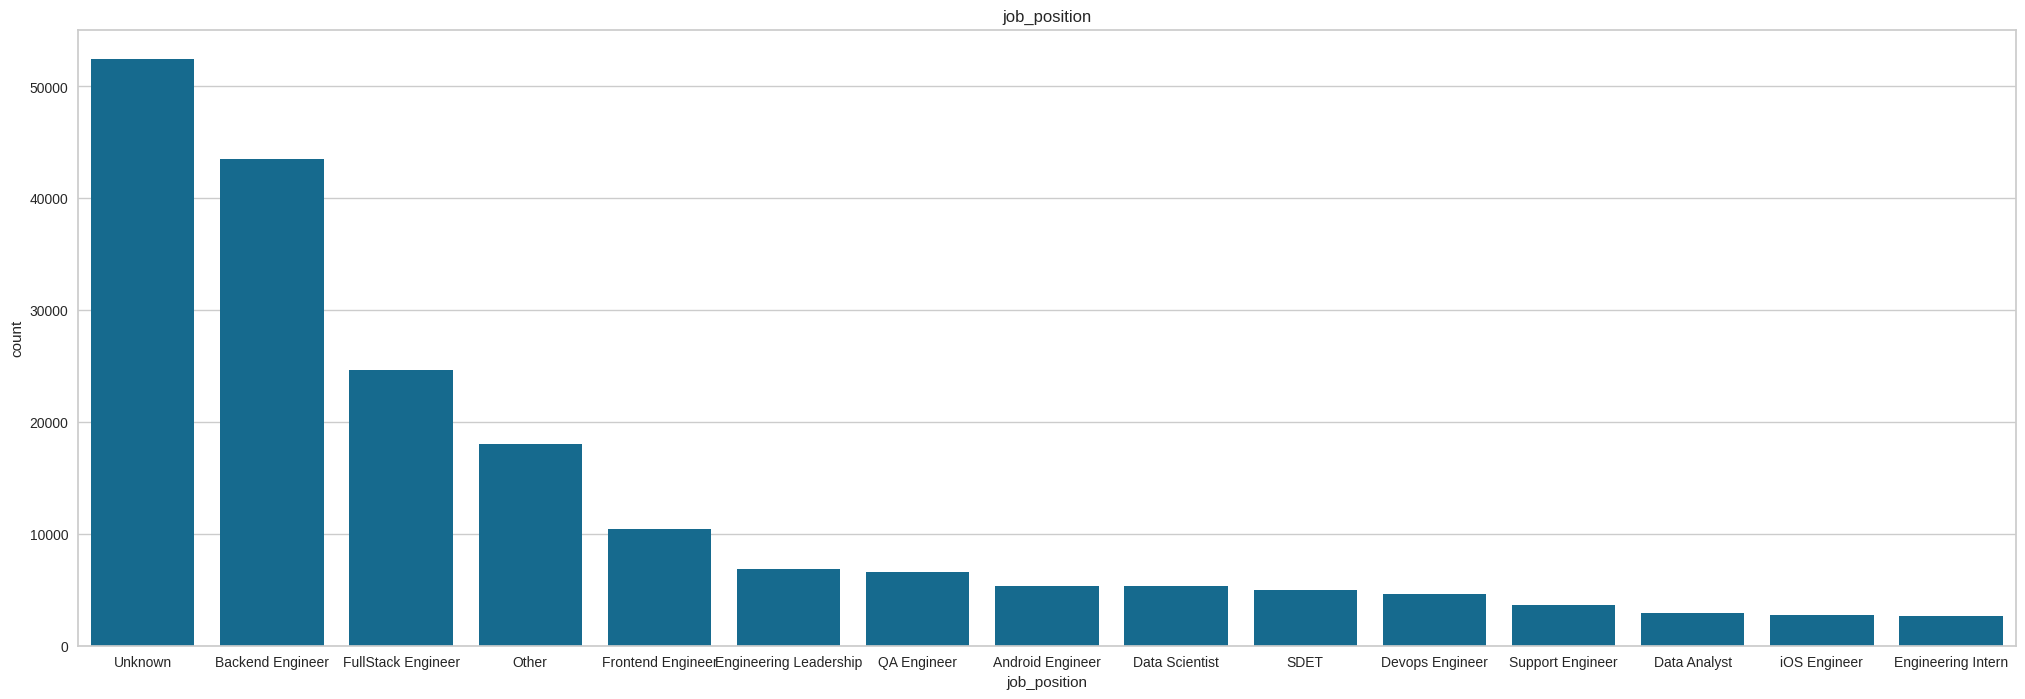

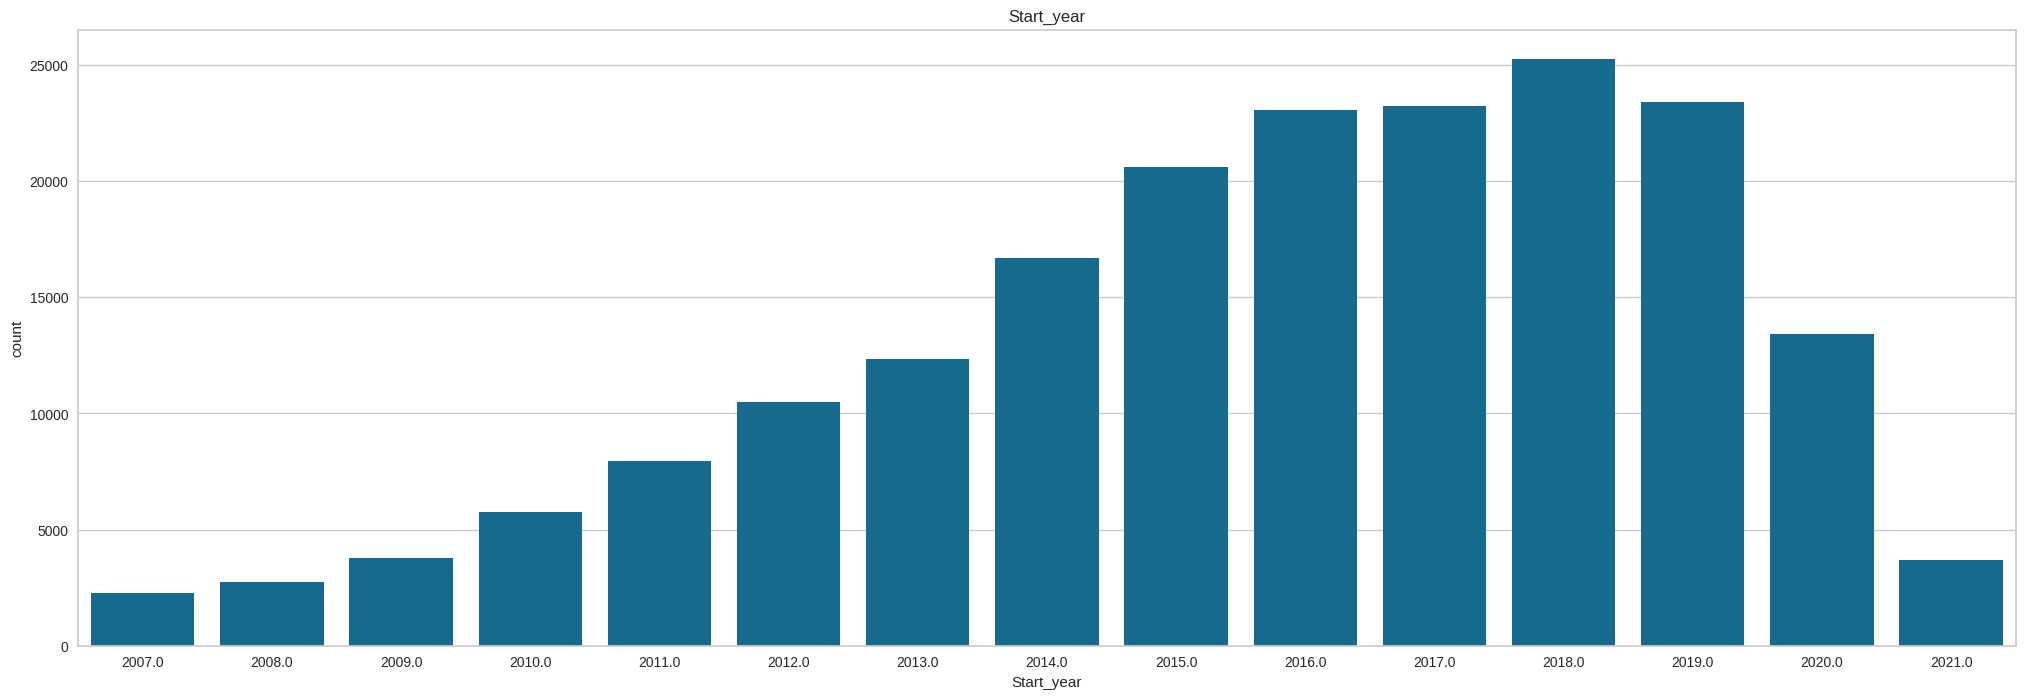

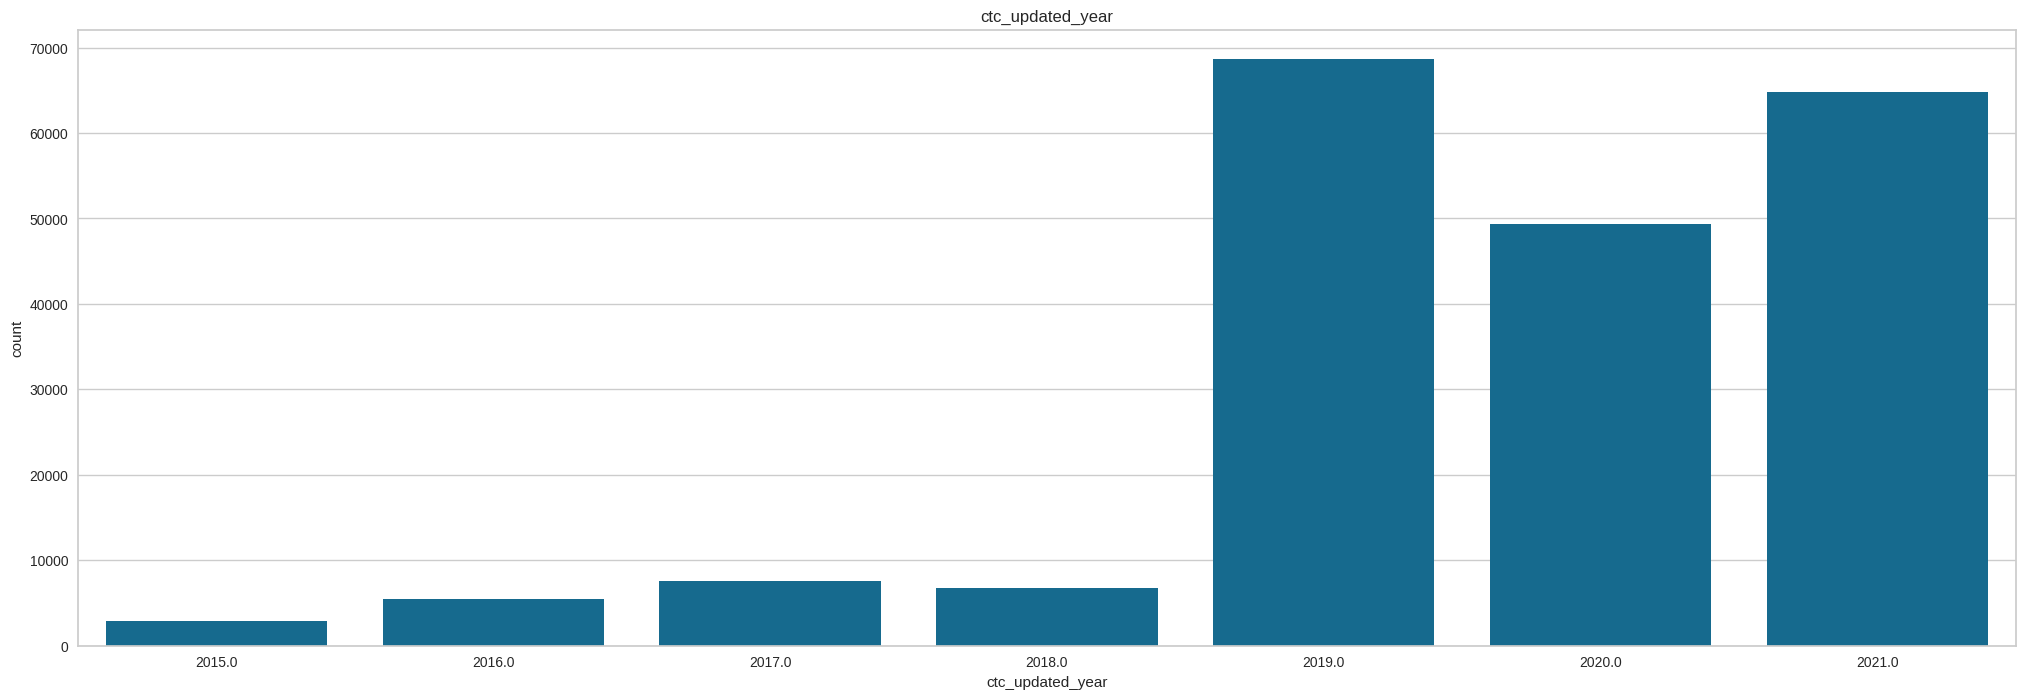

In [22]:
 categroical_columns = ['company','job_position','Start_year','ctc_updated_year']
numerical_columns = ['ctc','Years_of_Experience']
for i in categroical_columns:
    tmp = df.copy()
    tmp['count'] = 1
    tmp = tmp.groupby(i).sum()['count'].reset_index().sort_values('count',ascending=False).head(15)
    plt.figure(figsize=(25,8))
    sns.barplot(data=tmp,y='count',x=i).set(title=i)
    plt.show()


<ipython-input-23-dce1774f8099>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['ctc'], kde=True, color='blue')


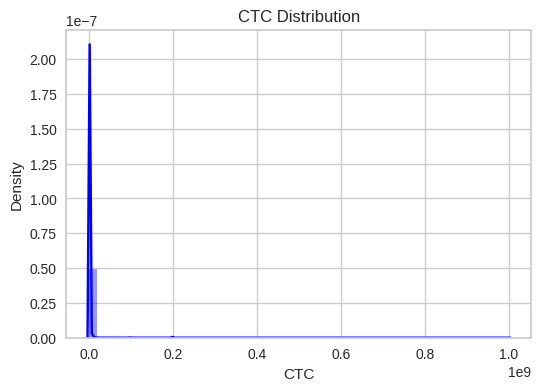

In [23]:
plt.figure(figsize=(6, 4))
sns.distplot(df['ctc'], kde=True, color='blue')
plt.title('CTC Distribution')
plt.xlabel('CTC')
plt.ylabel('Density')
plt.show()

Outlier Removal using IQR


In [24]:
outlier_removed = df.copy()

# Print initial shape
print(f"Initial Shape: {outlier_removed.shape}")

# Columns to check for outliers
cols = ['ctc']  # Specify one or more columns

# Calculate the Interquartile Range (IQR)
Q1 = outlier_removed[cols].quantile(0.25)  # 25th percentile
Q3 = outlier_removed[cols].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1

# Filter the dataset by removing outliers
outlier = outlier_removed[~((outlier_removed[cols] < (Q1 - 1.5 * IQR)) | (outlier_removed[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Print final shape
print(f"Shape after removing outliers: {outlier_removed.shape}")


Initial Shape: (205461, 8)
Shape after removing outliers: (205461, 8)


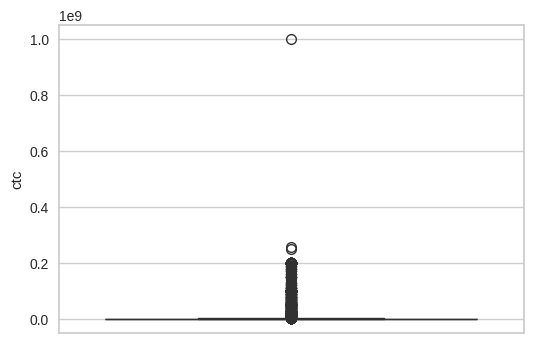

In [25]:
plt.figure(figsize=(6, 4))
out = outlier_removed['ctc']
sns.boxplot(out)
plt.show()

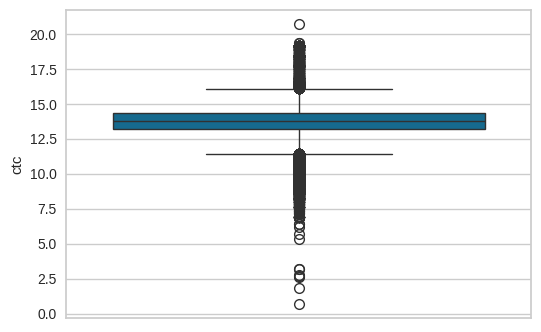

In [26]:
plt.figure(figsize=(6, 4))
out = np.log(outlier_removed['ctc'])
sns.boxplot(out)
plt.show()

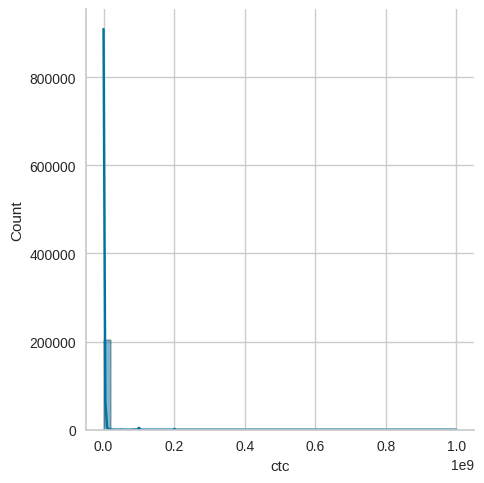

In [27]:
out = outlier_removed['ctc']
sns.displot(out,kde=True,bins=50)
plt.show()

Checking by converting the removed outliers to log

---



---



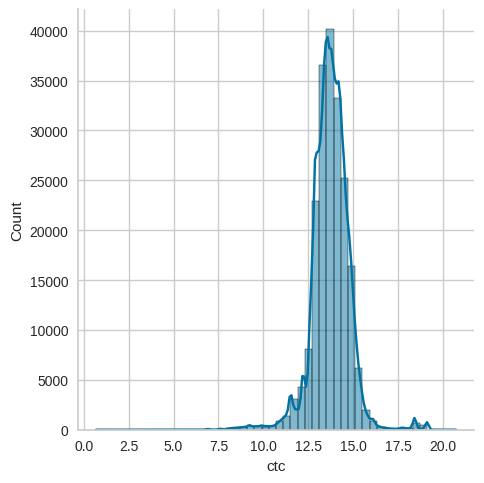

In [28]:
out = np.log(outlier_removed['ctc'])
sns.displot(out,kde=True,bins=50)
plt.show()

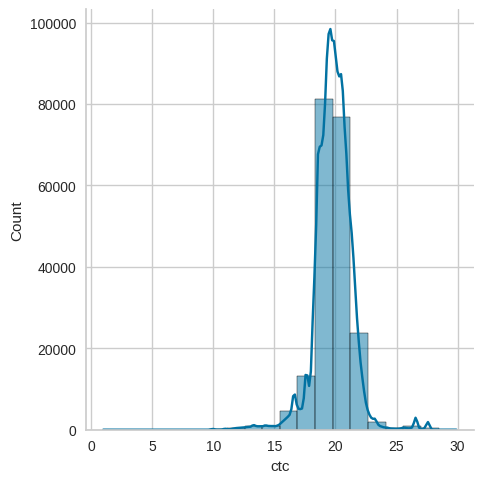

In [29]:
out2 = np.log2(outlier_removed['ctc'])
sns.displot(out2,kde=True,bins=20)
plt.show()

Multivariate Analysis


In [30]:
df_outlier_removed = outlier_removed.copy()

<ipython-input-31-3139aa4d427c>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tmp_jobs, x='ctc', y='job_position', palette='viridis').set(title="Top Paying Jobs")
<ipython-input-31-3139aa4d427c>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tmp_companies, x='ctc', y='company', palette='viridis').set(title="Top Paying Companies")


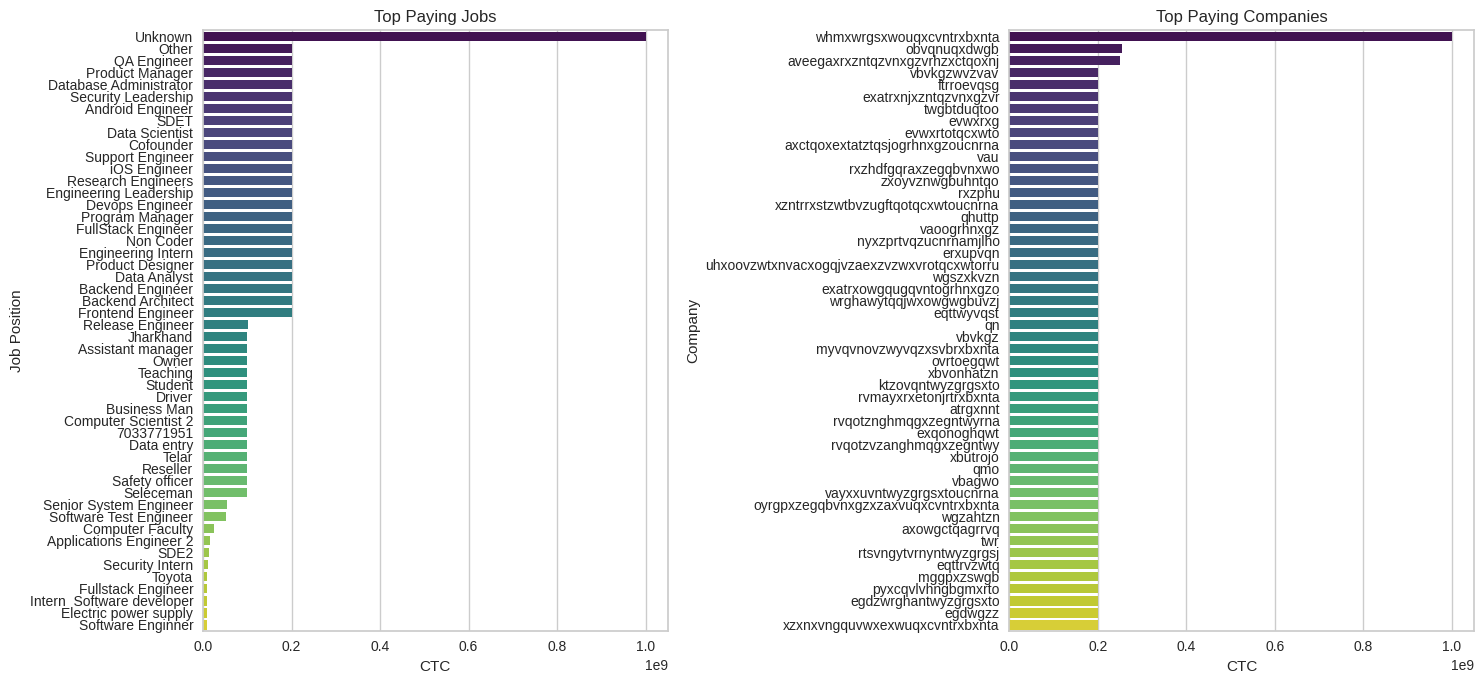

Top Job Positions:
['Unknown', 'Other', 'QA Engineer', 'Product Manager', 'Database Administrator', 'Security Leadership', 'Android Engineer', 'SDET', 'Data Scientist', 'Cofounder', 'Support Engineer', 'iOS Engineer', 'Research Engineers', 'Engineering Leadership', 'Devops Engineer', 'Program Manager', 'FullStack Engineer', 'Non Coder', 'Engineering Intern', 'Product Designer', 'Data Analyst', 'Backend Engineer', 'Backend Architect', 'Frontend Engineer', 'Release Engineer', 'Jharkhand', 'Assistant manager', 'Owner', 'Teaching', 'Student', 'Driver', 'Business Man', 'Computer Scientist 2', '7033771951', 'Data entry', 'Telar', 'Reseller', 'Safety officer', 'Seleceman', 'Senior System Engineer', 'Software Test Engineer', 'Computer Faculty', 'Applications Engineer 2', 'SDE2', 'Security Intern', 'Toyota', 'Fullstack Engineer', 'Intern  Software developer', 'Electric power supply', 'Software Enginner']
Top Companies:
['whmxwrgsxwouqxcvntrxbxnta', 'obvqnuqxdwgb', 'aveegaxrxzntqzvnxgzvrhzxctqox

In [31]:
# top-paying jobs
tmp_jobs = df.copy()
tmp_jobs = tmp_jobs.groupby(['job_position']).max()['ctc'].reset_index().sort_values('ctc', ascending=False).head(50)

#top-paying companies
tmp_companies = df.copy()
tmp_companies = tmp_companies.groupby(['company']).max()['ctc'].reset_index().sort_values('ctc', ascending=False).head(50)

plt.figure(figsize=(15, 7))

# Plot for Top Paying Jobs
plt.subplot(1, 2, 1)
sns.barplot(data=tmp_jobs, x='ctc', y='job_position', palette='viridis').set(title="Top Paying Jobs")
plt.xlabel('CTC')
plt.ylabel('Job Position')

# Plot for Top Paying Companies
plt.subplot(1, 2, 2)
sns.barplot(data=tmp_companies, x='ctc', y='company', palette='viridis').set(title="Top Paying Companies")
plt.xlabel('CTC')
plt.ylabel('Company')

# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# List the top job positions and companies
top_job_positions = list(tmp_jobs['job_position'])
top_companies = list(tmp_companies['company'])

print("Top Job Positions:")
print(top_job_positions)

print("Top Companies:")
print(top_companies)

Manual Clustering



In [32]:
df_outlier_removed

,employee_id,company,email_id,Start_year,ctc,job_position,ctc_updated_year,Years_of_Experience
0,0,atrgxnntxzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000.0,Other,2020.0,9
1,1,qtrxvzwtxzegwgbbrxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999.0,FullStack Engineer,2019.0,7
2,2,ojzwnvwnxwvx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000.0,Backend Engineer,2020.0,10
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000.0,Backend Engineer,2019.0,8
4,4,qxensqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000.0,FullStack Engineer,2019.0,8
...,...,...,...,...,...,...,...,...
205838,206918,vuurtxzw,70027b728c8ee901fe979533ed94ffda97be08fc23f33b...,2008.0,220000.0,Unknown,2019.0,17
205839,206919,husqvawgb,7f7292ffad724ebbe9ca860f515245368d714c84705b42...,2017.0,500000.0,Unknown,2020.0,8
205840,206920,vwwgrxnt,cb25cc7304e9a24facda7f5567c7922ffc48e3d5d6018c...,2021.0,700000.0,Unknown,2021.0,4
205841,206921,zgnvuurxwvmrt,fb46a1a2752f5f652ce634f6178d0578ef6995ee59f6c8...,2019.0,5100000.0,Unknown,2019.0,6


In [33]:
# Calculate the average CTC by company and years of experience for 'designation' flag
ctc_avg_by_dept = df_outlier_removed.groupby(['company', 'Years_of_Experience'])['ctc'].mean().reset_index()
ctc_avg_by_dept = ctc_avg_by_dept.rename(columns={'ctc': 'avg_ctc_dept'})

#Merge the department-level average CTC back into the original dataset
df = df_outlier_removed.merge(ctc_avg_by_dept, on=['company', 'Years_of_Experience'], how='left')

In [34]:
df

,employee_id,company,email_id,Start_year,ctc,job_position,ctc_updated_year,Years_of_Experience,avg_ctc_dept
0,0,atrgxnntxzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000.0,Other,2020.0,9,1.100000e+06
1,1,qtrxvzwtxzegwgbbrxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999.0,FullStack Engineer,2019.0,7,7.373787e+05
2,2,ojzwnvwnxwvx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000.0,Backend Engineer,2020.0,10,2.000000e+06
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000.0,Backend Engineer,2019.0,8,1.322632e+06
4,4,qxensqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000.0,FullStack Engineer,2019.0,8,1.400000e+06
...,...,...,...,...,...,...,...,...,...
205456,206918,vuurtxzw,70027b728c8ee901fe979533ed94ffda97be08fc23f33b...,2008.0,220000.0,Unknown,2019.0,17,2.200000e+05
205457,206919,husqvawgb,7f7292ffad724ebbe9ca860f515245368d714c84705b42...,2017.0,500000.0,Unknown,2020.0,8,1.085882e+06
205458,206920,vwwgrxnt,cb25cc7304e9a24facda7f5567c7922ffc48e3d5d6018c...,2021.0,700000.0,Unknown,2021.0,4,6.571429e+05
205459,206921,zgnvuurxwvmrt,fb46a1a2752f5f652ce634f6178d0578ef6995ee59f6c8...,2019.0,5100000.0,Unknown,2019.0,6,5.891461e+06


In [35]:
# Create the 'designation' flag based on CTC comparison with average department CTC
def set_designation_flag(row):
    if row['ctc'] < row['avg_ctc_dept']:
        return 1  # Below average
    elif row['ctc'] == row['avg_ctc_dept']:
        return 2  # Equal to average
    else:
        return 3  # Above average

In [36]:
df['designation'] = df.apply(set_designation_flag, axis=1)

In [37]:
# Calculate the average CTC by company, job position, and years of experience for 'Class' flag
ctc_avg_by_class = df.groupby(['company', 'job_position', 'Years_of_Experience'])['ctc'].mean().reset_index()
ctc_avg_by_class = ctc_avg_by_class.rename(columns={'ctc': 'avg_ctc_class'})

In [38]:
df = df.merge(ctc_avg_by_class, on=['company', 'job_position', 'Years_of_Experience'], how='left')

In [39]:
# Create the 'Class' flag based on CTC comparison with average company & job position CTC
def set_class_flag(row):
    if row['ctc'] < row['avg_ctc_class']:
        return 1  # Below average
    elif row['ctc'] == row['avg_ctc_class']:
        return 2  # Equal to average
    else:
        return 3  # Above average

In [40]:
df['Class'] = df.apply(set_class_flag, axis=1)

In [41]:
# Calculate the average CTC by company and years of experience for 'Tier' flag
ctc_avg_by_tier = df.groupby(['company', 'Years_of_Experience'])['ctc'].mean().reset_index()
ctc_avg_by_tier = ctc_avg_by_tier.rename(columns={'ctc': 'avg_ctc_tier'})

In [42]:
# Merge the company-level average CTC back into the original dataset
df = df.merge(ctc_avg_by_tier, on=['company', 'Years_of_Experience'], how='left')

In [43]:
# Create the 'Tier' flag based on CTC comparison with average company CTC
def set_tier_flag(row):
    if row['ctc'] < row['avg_ctc_tier']:
        return 1  # Below average
    elif row['ctc'] == row['avg_ctc_tier']:
        return 2  # Equal to average
    else:
        return 3  # Above average


In [44]:
df['Tier'] = df.apply(set_tier_flag, axis=1)
df

,employee_id,company,email_id,Start_year,ctc,job_position,ctc_updated_year,Years_of_Experience,avg_ctc_dept,designation,avg_ctc_class,Class,avg_ctc_tier,Tier
0,0,atrgxnntxzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000.0,Other,2020.0,9,1.100000e+06,2,1.100000e+06,2,1.100000e+06,2
1,1,qtrxvzwtxzegwgbbrxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999.0,FullStack Engineer,2019.0,7,7.373787e+05,1,7.742856e+05,1,7.373787e+05,1
2,2,ojzwnvwnxwvx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000.0,Backend Engineer,2020.0,10,2.000000e+06,2,2.000000e+06,2,2.000000e+06,2
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000.0,Backend Engineer,2019.0,8,1.322632e+06,1,1.158571e+06,1,1.322632e+06,1
4,4,qxensqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000.0,FullStack Engineer,2019.0,8,1.400000e+06,2,1.400000e+06,2,1.400000e+06,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205456,206918,vuurtxzw,70027b728c8ee901fe979533ed94ffda97be08fc23f33b...,2008.0,220000.0,Unknown,2019.0,17,2.200000e+05,2,2.200000e+05,2,2.200000e+05,2
205457,206919,husqvawgb,7f7292ffad724ebbe9ca860f515245368d714c84705b42...,2017.0,500000.0,Unknown,2020.0,8,1.085882e+06,1,1.150000e+06,1,1.085882e+06,1
205458,206920,vwwgrxnt,cb25cc7304e9a24facda7f5567c7922ffc48e3d5d6018c...,2021.0,700000.0,Unknown,2021.0,4,6.571429e+05,3,6.666667e+05,3,6.571429e+05,3
205459,206921,zgnvuurxwvmrt,fb46a1a2752f5f652ce634f6178d0578ef6995ee59f6c8...,2019.0,5100000.0,Unknown,2019.0,6,5.891461e+06,1,5.920732e+06,1,5.891461e+06,1


1. Top 10 employees (earning more than most of the employees in the company) - Tier 1:

In [45]:
top_10_tier_1 = df[df['Tier'] == 1].groupby('company').apply(lambda x: x.nlargest(10, 'ctc')).reset_index(drop=True)
top_10_tier_1 = top_10_tier_1.head(10)
print(top_10_tier_1[['employee_id', 'job_position', 'ctc', 'Tier']])

   employee_id            job_position        ctc  Tier
0        13280      FullStack Engineer   410000.0     1
1       100004       Frontend Engineer   400000.0     1
2       109189      FullStack Engineer   400000.0     1
3        11130                   Other   500000.0     1
4        15387                 Unknown   500000.0     1
5        62158        Backend Engineer  1800000.0     1
6        93599        Product Designer  1730000.0     1
7       115696        Backend Engineer  1600000.0     1
8       203546  Engineering Leadership  1600000.0     1
9        51815                   Other  1500000.0     1


<ipython-input-45-5459a6558e9f>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_tier_1 = df[df['Tier'] == 1].groupby('company').apply(lambda x: x.nlargest(10, 'ctc')).reset_index(drop=True)


2. Top 10 employees of data science in each company earning more than their peers - Class 1


In [46]:
top_10_class_1_data_science = df[(df['job_position'] == 'Data Scientist') & (df['Class'] == 1)]
top_10_class_1_data_science = top_10_class_1_data_science.groupby('company').apply(lambda x: x.nlargest(10, 'ctc')).reset_index(drop=True)
top_10_class_1_data_science = top_10_class_1_data_science.head(10)
top_10_class_1_data_science = top_10_class_1_data_science[['employee_id', 'job_position', 'ctc', 'Class']]
top_10_class_1_data_science

<ipython-input-46-1a9f3222de0f>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_class_1_data_science = top_10_class_1_data_science.groupby('company').apply(lambda x: x.nlargest(10, 'ctc')).reset_index(drop=True)


,employee_id,job_position,ctc,Class
0,106613,Data Scientist,1200000.0,1
1,161190,Data Scientist,880000.0,1
2,80279,Data Scientist,800000.0,1
3,122140,Data Scientist,700000.0,1
4,54042,Data Scientist,850000.0,1
5,107906,Data Scientist,1550000.0,1
6,178842,Data Scientist,1250000.0,1
7,144082,Data Scientist,1200000.0,1
8,200229,Data Scientist,1200000.0,1
9,176859,Data Scientist,1190000.0,1


3. Bottom 10 employees of data science in each company earning less than their peers - Class 3


In [47]:
bottom_10_class_3_data_science = df[(df['job_position'] == 'Data Scientist') & (df['Class'] == 3)]
bottom_10_class_3_data_science = bottom_10_class_3_data_science.groupby('company').apply(lambda x: x.nsmallest(10, 'ctc')).reset_index(drop=True)
bottom_10_class_3_data_science = bottom_10_class_3_data_science.head(10)
bottom_10_class_3_data_science = bottom_10_class_3_data_science[['employee_id', 'job_position', 'ctc', 'Class']]
bottom_10_class_3_data_science


<ipython-input-47-f6b1ce9d95ff>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bottom_10_class_3_data_science = bottom_10_class_3_data_science.groupby('company').apply(lambda x: x.nsmallest(10, 'ctc')).reset_index(drop=True)


,employee_id,job_position,ctc,Class
0,165530,Data Scientist,1800000.0,3
1,74350,Data Scientist,850000.0,3
2,36316,Data Scientist,1220000.0,3
3,11561,Data Scientist,1680000.0,3
4,206408,Data Scientist,1100000.0,3
5,90369,Data Scientist,1150000.0,3
6,154852,Data Scientist,1150000.0,3
7,65298,Data Scientist,1160000.0,3
8,99386,Data Scientist,1310000.0,3
9,89719,Data Scientist,1400000.0,3


4. Bottom 10 employees (earning less than most of the employees in the company) - Tier 3


In [48]:
# Filter out rows where job_position is 'Others' or 'Unknown'
df_filtered1 = df[~df['job_position'].isin(['Other', 'Unknown'])]

bottom_10_tier_3 = df_filtered1[df_filtered1['Tier'] == 3].groupby('company').apply(lambda x: x.nsmallest(10, 'ctc')).reset_index(drop=True)
bottom_10_tier_3 = bottom_10_tier_3.head(10)
bottom_10_tier_3 = bottom_10_tier_3[['employee_id', 'job_position', 'ctc', 'Tier']]
bottom_10_tier_3

<ipython-input-48-a15e0f105c12>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bottom_10_tier_3 = df_filtered1[df_filtered1['Tier'] == 3].groupby('company').apply(lambda x: x.nsmallest(10, 'ctc')).reset_index(drop=True)


,employee_id,job_position,ctc,Tier
0,140181,Data Scientist,1100000.0,3
1,175721,Backend Engineer,1100000.0,3
2,63841,Backend Engineer,1200000.0,3
3,38633,Backend Engineer,1300000.0,3
4,154247,FullStack Engineer,1300000.0,3
5,151872,Backend Engineer,1350000.0,3
6,176160,FullStack Engineer,1350000.0,3
7,55160,FullStack Engineer,1400000.0,3
8,175772,Backend Engineer,1400000.0,3
9,20642,FullStack Engineer,1600000.0,3


5. Top 10 employees in each company - Data Scientist department - having 5/6/7 years of experience earning more than their peers - Tier X


In [49]:
df_10_by_experience = df[(df['job_position'] == 'Data Scientist') & (df['Years_of_Experience'].isin([5, 6, 7]))]
df_10_by_experience = df_10_by_experience.groupby('company').apply(lambda x: x.nlargest(10, 'ctc')).reset_index(drop=True)
df_10_by_experience = df_10_by_experience.head(10)
df_10_by_experience = df_10_by_experience[['employee_id', 'company', 'job_position', 'ctc', 'Years_of_Experience']]
df_10_by_experience

<ipython-input-49-164722f52b97>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_10_by_experience = df_10_by_experience.groupby('company').apply(lambda x: x.nlargest(10, 'ctc')).reset_index(drop=True)


,employee_id,company,job_position,ctc,Years_of_Experience
0,117081,10dvxrtvqzxzs,Data Scientist,400000.0,5
1,140181,1bs,Data Scientist,1100000.0,7
2,125001,2020,Data Scientist,2100000.0,5
3,136321,247vx,Data Scientist,1100000.0,7
4,165530,3pntwyzgrgsxto,Data Scientist,1800000.0,7
5,106613,3pntwyzgrgsxto,Data Scientist,1200000.0,7
6,160549,3pntwyzgrgsxto,Data Scientist,1000000.0,6
7,144259,3rgi,Data Scientist,800000.0,7
8,195788,Unknown,Data Scientist,2000000.0,6
9,99735,aaw,Data Scientist,88555.0,7


6. Top 10 companies (based on their CTC)


In [50]:
top_10_companies_by_ctc = df.groupby('company')['ctc'].mean().sort_values(ascending=False).head(10).reset_index()
top_10_companies_by_ctc

,company,ctc
0,whmxwrgsxwouqxcvntrxbxnta,1.000150e+09
1,aveegaxrxzntqzvnxgzvrhzxctqoxnj,2.500000e+08
2,ehlxonh,2.000000e+08
3,vayxxuvntwyzgrgsxtoucnrna,2.000000e+08
4,axctqoxextatztqsjogrhnxgzoucnrna,2.000000e+08
5,ofvbxcxctpvzvzavxzonxnhntgeowxtzwtvzantwyzgrgsj,2.000000e+08
6,touxqxnntwyzgrgsxtoucnrna,2.000000e+08
7,nwjgzrxzt,2.000000e+08
8,mvpyntqnqvaxzs,2.000000e+08
9,qn,2.000000e+08


Top 2 positions in every company (based on their CTC)


In [51]:
# Filter out rows where job_position is 'Others' or 'Unknown'
df_filtered = df[~df['job_position'].isin(['Other', 'Unknown'])]

# top 2 positions per company based on CTC
top_2_positions = df_filtered.groupby(['company', 'job_position']).apply(lambda x: x.nlargest(2, 'ctc')).reset_index(drop=True)

#  top 2 positions per company
top_2_positions = top_2_positions.groupby('company').head(2).reset_index(drop=True)
top_2_positions = top_2_positions[['company', 'job_position', 'ctc']]
top_2_positions

<ipython-input-51-9eda17178f1c>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_2_positions = df_filtered.groupby(['company', 'job_position']).apply(lambda x: x.nlargest(2, 'ctc')).reset_index(drop=True)


,company,job_position,ctc
0,01ojztqsj,Android Engineer,270000.0
1,01ojztqsj,Frontend Engineer,830000.0
2,05mzexzytvrnyuqxcvntrxbxnta,Backend Engineer,1100000.0
3,10,Backend Engineer,450000.0
4,1000uqgltwn,Frontend Engineer,600000.0
...,...,...,...
39163,zxzvnxgzvrxzonqhbtzno,FullStack Engineer,1350000.0
39164,zxzvzxjvsqghu,Engineering Leadership,1180000.0
39165,zyuwrxbxnta,Frontend Engineer,2400000.0
39166,zyvzwtwgzohrnxzstzsxzttqo,Frontend Engineer,940000.0


Scaling the Dataset

In [52]:
data = df.drop(columns = ['avg_ctc_dept','designation', 'avg_ctc_class', 'Class', 'avg_ctc_tier', 'Tier'])
data

,employee_id,company,email_id,Start_year,ctc,job_position,ctc_updated_year,Years_of_Experience
0,0,atrgxnntxzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000.0,Other,2020.0,9
1,1,qtrxvzwtxzegwgbbrxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999.0,FullStack Engineer,2019.0,7
2,2,ojzwnvwnxwvx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000.0,Backend Engineer,2020.0,10
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000.0,Backend Engineer,2019.0,8
4,4,qxensqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000.0,FullStack Engineer,2019.0,8
...,...,...,...,...,...,...,...,...
205456,206918,vuurtxzw,70027b728c8ee901fe979533ed94ffda97be08fc23f33b...,2008.0,220000.0,Unknown,2019.0,17
205457,206919,husqvawgb,7f7292ffad724ebbe9ca860f515245368d714c84705b42...,2017.0,500000.0,Unknown,2020.0,8
205458,206920,vwwgrxnt,cb25cc7304e9a24facda7f5567c7922ffc48e3d5d6018c...,2021.0,700000.0,Unknown,2021.0,4
205459,206921,zgnvuurxwvmrt,fb46a1a2752f5f652ce634f6178d0578ef6995ee59f6c8...,2019.0,5100000.0,Unknown,2019.0,6


In [53]:
data['ctc_log'] = np.log2(data['ctc'])

In [54]:
drop_cols = ['email_id','employee_id']
for i in drop_cols:
    try:
        data.drop([i],axis=1,inplace=True)
    except:
        print('no')

In [55]:
df_model = data.copy()
df_model

,company,Start_year,ctc,job_position,ctc_updated_year,Years_of_Experience,ctc_log
0,atrgxnntxzaxv,2016.0,1100000.0,Other,2020.0,9,20.069072
1,qtrxvzwtxzegwgbbrxbxnta,2018.0,449999.0,FullStack Engineer,2019.0,7,18.779562
2,ojzwnvwnxwvx,2015.0,2000000.0,Backend Engineer,2020.0,10,20.931569
3,ngpgutaxv,2017.0,700000.0,Backend Engineer,2019.0,8,19.416995
4,qxensqghu,2017.0,1400000.0,FullStack Engineer,2019.0,8,20.416995
...,...,...,...,...,...,...,...
205456,vuurtxzw,2008.0,220000.0,Unknown,2019.0,17,17.747144
205457,husqvawgb,2017.0,500000.0,Unknown,2020.0,8,18.931569
205458,vwwgrxnt,2021.0,700000.0,Unknown,2021.0,4,19.416995
205459,zgnvuurxwvmrt,2019.0,5100000.0,Unknown,2019.0,6,22.282066


In [56]:
df_model.isnull().sum()

,0
company,0
Start_year,0
ctc,0
job_position,0
ctc_updated_year,0
Years_of_Experience,0
ctc_log,0


In [57]:
le = LabelEncoder()

# Encode company and job_position
df_model['company_encoded'] = le.fit_transform(data['company'])
df_model['job_position_encoded'] = le.fit_transform(data['job_position'])
df_model = df_model.drop(['company', 'job_position'], axis=1)

In [58]:
df_model

,Start_year,ctc,ctc_updated_year,Years_of_Experience,ctc_log,company_encoded,job_position_encoded
0,2016.0,1100000.0,2020.0,9,20.069072,948,452
1,2018.0,449999.0,2019.0,7,18.779562,19307,288
2,2015.0,2000000.0,2020.0,10,20.931569,15174,138
3,2017.0,700000.0,2019.0,8,19.416995,11854,138
4,2017.0,1400000.0,2019.0,8,20.416995,19803,288
...,...,...,...,...,...,...,...
205456,2008.0,220000.0,2019.0,17,17.747144,28145,939
205457,2017.0,500000.0,2020.0,8,18.931569,8335,939
205458,2021.0,700000.0,2021.0,4,19.416995,28478,939
205459,2019.0,5100000.0,2019.0,6,22.282066,35274,939


In [59]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_model[['Start_year', 'ctc', 'Years_of_Experience', 'ctc_log', 'ctc_updated_year']])

# Combine scaled features with encoded columns
processed_data = pd.DataFrame(scaled_features, columns=['Start_year', 'ctc', 'Years_of_Experience', 'ctc_log', 'ctc_updated_year'])
processed_data['company_encoded'] = df_model['company_encoded']
processed_data['job_position_encoded'] = df_model['job_position_encoded']

In [60]:
processed_data

,Start_year,ctc,Years_of_Experience,ctc_log,ctc_updated_year,company_encoded,job_position_encoded
0,0.211792,-0.098704,-0.211832,0.156579,0.281656,948,452
1,0.685111,-0.154160,-0.685151,-0.691854,-0.472813,19307,288
2,-0.024867,-0.021919,0.024827,0.724059,0.281656,15174,138
3,0.448452,-0.132831,-0.448492,-0.272455,-0.472813,11854,138
4,0.448452,-0.073109,-0.448492,0.385496,-0.472813,19803,288
...,...,...,...,...,...,...,...
205456,-1.681483,-0.173783,1.681442,-1.371135,-0.472813,28145,939
205457,0.448452,-0.149894,-0.448492,-0.591842,0.281656,8335,939
205458,1.395090,-0.132831,-1.395129,-0.272455,1.036124,28478,939
205459,0.921771,0.242564,-0.921811,1.612620,-0.472813,35274,939


In [61]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform

def hopkins(X):
    d = X.shape[1]
    n = len(X) // 10
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    rand_X = uniform(X.min(axis=0), X.max(axis=0), (n, d))
    u_distances, _ = nbrs.kneighbors(rand_X)
    x_distances, _ = nbrs.kneighbors(sample(list(X), n))
    u_sum = sum(u_distances)
    x_sum = sum(x_distances)
    return u_sum / (u_sum + x_sum)

print(f"Hopkins statistic: {hopkins(processed_data.values)}")

Hopkins statistic: [1.]


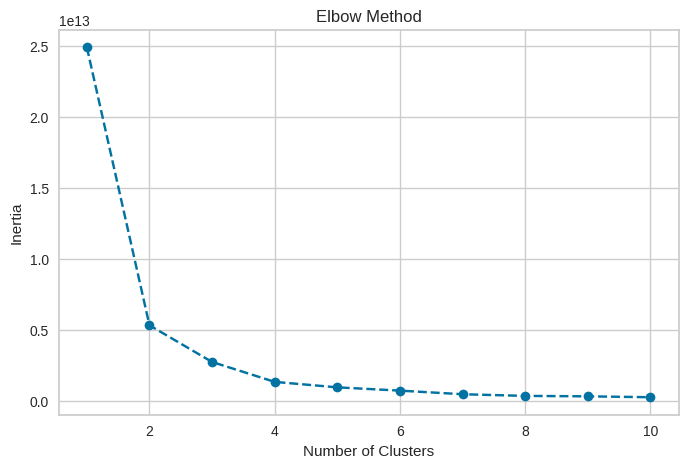

In [74]:
# Elbow method
inertia = []
range_clusters = range(1, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(processed_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [67]:
processed_data

,Start_year,ctc,Years_of_Experience,ctc_log,ctc_updated_year,company_encoded,job_position_encoded,Cluster
0,0.211792,-0.098704,-0.211832,0.156579,0.281656,948,452,1
1,0.685111,-0.154160,-0.685151,-0.691854,-0.472813,19307,288,0
2,-0.024867,-0.021919,0.024827,0.724059,0.281656,15174,138,1
3,0.448452,-0.132831,-0.448492,-0.272455,-0.472813,11854,138,1
4,0.448452,-0.073109,-0.448492,0.385496,-0.472813,19803,288,0
...,...,...,...,...,...,...,...,...
205456,-1.681483,-0.173783,1.681442,-1.371135,-0.472813,28145,939,0
205457,0.448452,-0.149894,-0.448492,-0.591842,0.281656,8335,939,1
205458,1.395090,-0.132831,-1.395129,-0.272455,1.036124,28478,939,0
205459,0.921771,0.242564,-0.921811,1.612620,-0.472813,35274,939,0


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


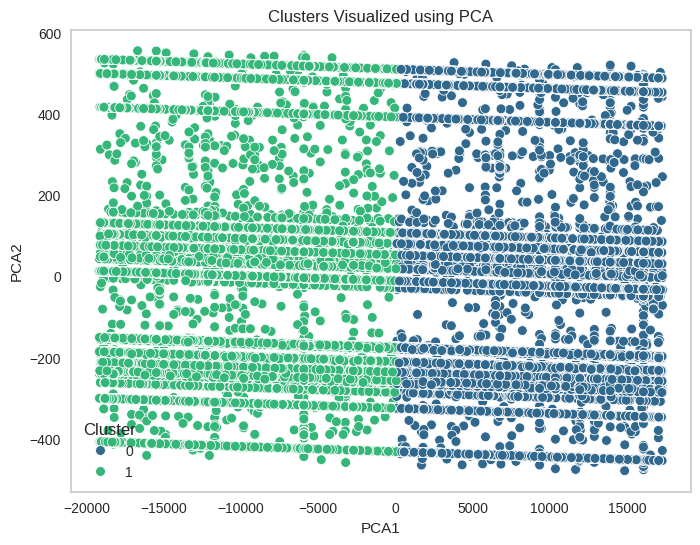

In [81]:
# K-means Clustering
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(processed_data)

# Add cluster labels to the original dataframe
df['Cluster'] = clusters

# Visualizing cluster centers (2D plot using PCA)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(processed_data)
df['PCA1'] = pca_data[:, 0]
df['PCA2'] = pca_data[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50)
plt.title('Clusters Visualized using PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid()
plt.show()


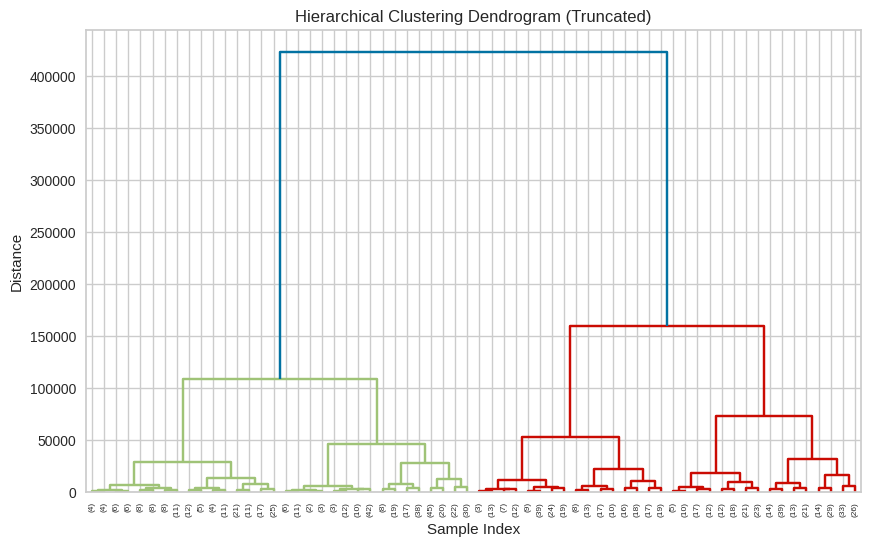

In [82]:
# Hierarchical Clustering
sample_data = processed_data[:1000]  # Use a subset for performance

# Generate the linkage matrix
linkage_matrix = linkage(sample_data, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agg_clusters = agg_clustering.fit_predict(sample_data)


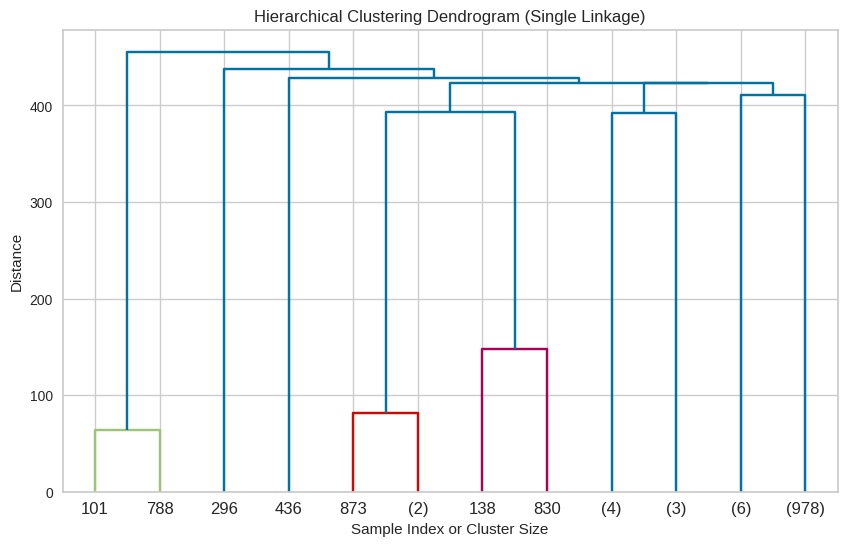

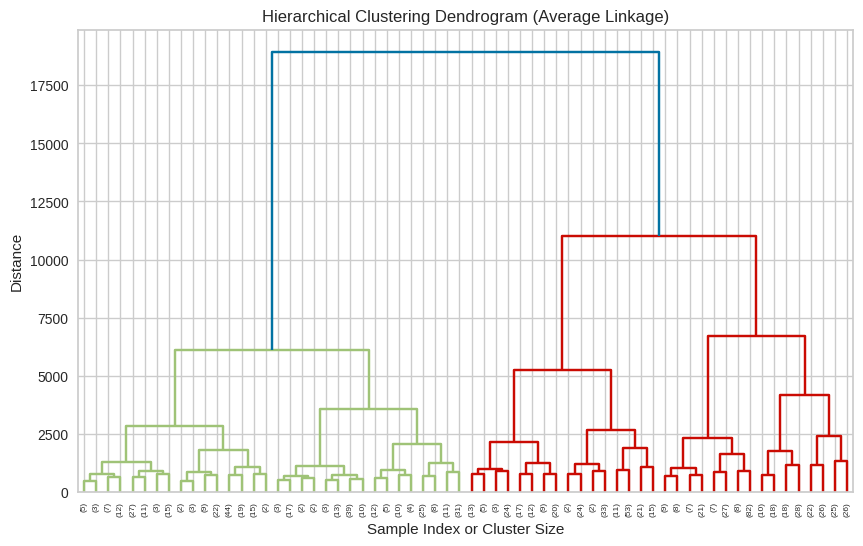

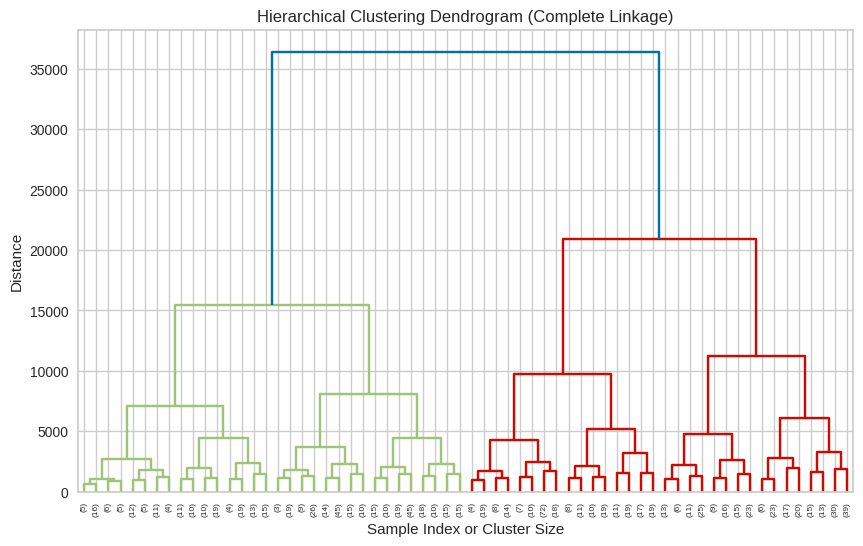

In [83]:

# Sample the data (use a smaller sample for visualization if needed)
sample_data = processed_data[:1000]  # Use the first 1000 rows for simplicity

# Function to plot dendrograms
def plot_dendrogram(linkage_matrix, method):
    plt.figure(figsize=(10, 6))
    dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Truncate for better visualization
    plt.title(f'Hierarchical Clustering Dendrogram ({method} Linkage)')
    plt.xlabel('Sample Index or Cluster Size')
    plt.ylabel('Distance')
    plt.show()

# Single Linkage
single_linkage = linkage(sample_data, method='single')
plot_dendrogram(single_linkage, 'Single')

# Average Linkage
average_linkage = linkage(sample_data, method='average')
plot_dendrogram(average_linkage, 'Average')

# Complete Linkage
complete_linkage = linkage(sample_data, method='complete')
plot_dendrogram(complete_linkage, 'Complete')